In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Loading Libraries

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print(os.listdir("/content/drive/MyDrive/Colab Notebooks/"))

['.ipynb_checkpoints', 'sampleSubmission.csv', 'Submission.csv', 'test.gsheet', 'train.gsheet', 'train.tsv', 'test.tsv', 'temp', 'movie-review-prediction.ipynb']


In [3]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,Dropout,Embedding,LSTM
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential
from keras.utils import plot_model

import random
import tensorflow

#set random seed for the session and also for tensorflow that runs in background for keras
tensorflow.random.set_seed(123)
random.seed(123)

# Load Dataset

In [4]:
train= pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train.tsv", sep="\t")
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/test.tsv", sep="\t")

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156058 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66292 entries, 0 to 66291
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   PhraseId    66292 non-null  int64 
 1   SentenceId  66292 non-null  int64 
 2   Phrase      66289 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


In [7]:
test=test[:15000]

In [8]:
pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 7.2 MB/s eta 0:00:00


# Function for cleaning the reviews, tokenize and lemmatize them.

In [10]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import re
import string
import emoji
from tqdm import tqdm

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_sentences(df):
    reviews = []

     # Fill NaN values with empty strings and ensure all entries are strings
    df['Phrase'] = df['Phrase'].fillna('').astype(str)

    for sent in tqdm(df['Phrase']):
        # Remove HTML tags
        review_text = BeautifulSoup(sent, "html.parser").get_text()

        # Remove URLs
        review_text = re.sub(r"http\S+|www\S+|https\S+", '', review_text, flags=re.MULTILINE)

        # Convert emojis to textual representation and remove them
        review_text = emoji.demojize(review_text)
        review_text = re.sub(r':[a-z_]+:', '', review_text)

        # Remove punctuation
        review_text = review_text.translate(str.maketrans('', '', string.punctuation))

        # Remove numbers
        review_text = re.sub(r'\d+', '', review_text)

        # Tokenize the sentences
        words = word_tokenize(review_text.lower())

        # Remove stop words and lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

        reviews.append(lemma_words)

    return reviews

train_sentences = clean_sentences(train)
test_sentences = clean_sentences(test)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
  2%|▏         | 2439/156060 [00:03<02:54, 882.48it/s]<ipython-input-10-7121d66130b8>:26: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(sent, "html.parser").get_text()
 14%|█▍        | 2096/15000 [00:00<00:03, 4209.73it/s]<ipython-input-10-7121d66130b8>:26: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(sent, "html.parser").get_text()
100%|██████████| 15000/15000 [00:03<0

In [11]:
# Print the first 5 cleaned sentences from the train dataset
print("First 5 cleaned sentences from the train dataset:")
for i in range(5):
    print(train_sentences[i])

# Print the first 5 cleaned sentences from the test dataset
print("\nFirst 5 cleaned sentences from the test dataset:")
for i in range(5):
    print(test_sentences[i])

First 5 cleaned sentences from the train dataset:
['midnight', 'haunting', 'complete', 'waste', 'time', 'plot', 'incoherent', 'acting', 'wooden', 'special', 'effect', 'laughable']
['love', 'digital', 'age', 'potential', 'ultimately', 'fall', 'flat', 'premise', 'interesting', 'execution', 'lacking', 'character', 'underdeveloped', 'dialogue', 'often', 'feel', 'forced']
['space', 'explorer', 'average', 'scifi', 'adventure', 'offer', 'decent', 'visual', 'effect', 'thrilling', 'moment', 'doesnt', 'really', 'break', 'new', 'ground']
['great', 'escape', 'solid', 'action', 'movie', 'delivers', 'plenty', 'excitement', 'pacing', 'brisk', 'set', 'piece', 'wellexecuted']
['whimsical', 'wonder', 'absolute', 'delight', 'start', 'finish', 'film', 'brimming', 'charm', 'creativity', 'heart', 'character', 'wonderfully', 'developed', 'story', 'touching', 'uplifting']

First 5 cleaned sentences from the test dataset:
['feel', 'like', 'cheap', 'knockoff', 'every', 'horror', 'movie', 'cliché', 'thrown', 'to

## Collect the dependent values and convert to one-hot encoded output using to_categorical

In [12]:
target=train.Sentiment.values
y_target=to_categorical(target)
num_classes=y_target.shape[1]

##split into train and validation sets

In [13]:
X_train,X_val,y_train,y_val=train_test_split(train_sentences,y_target,test_size=0.2,stratify=y_target)

In [14]:
# Print the shapes of the datasets
print("Shape of X_train:", len(X_train))
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", len(X_val))
print("Shape of y_val:", y_val.shape)

# Print the first 5 samples of the training dataset
print("\nFirst 5 samples of the training dataset:")
for i in range(5):
    print("Sentence:", X_train[i])
    print("Label:", y_train[i])

print()
print()

# Print the first 5 samples of the validation dataset
print("\nFirst 5 samples of the validation dataset:")
for i in range(5):
    print("Sentence:", X_val[i])
    print("Label:", y_val[i])

Shape of X_train: 124848
Shape of y_train: (124848, 5)
Shape of X_val: 31212
Shape of y_val: (31212, 5)

First 5 samples of the training dataset:
Sentence: ['rachel', 'griffith']
Label: [0. 0. 1. 0. 0.]
Sentence: ['even', 'hastily', 'amateurishly', 'drawn', 'animation', 'engage']
Label: [1. 0. 0. 0. 0.]
Sentence: ['pulpy', 'concept', 'many', 'hand', 'would', 'completely', 'forgettable']
Label: [0. 0. 0. 1. 0.]
Sentence: ['tragically']
Label: [0. 1. 0. 0. 0.]
Sentence: ['film', 'nearly', 'terminal', 'case', 'cutis']
Label: [0. 0. 1. 0. 0.]



First 5 samples of the validation dataset:
Sentence: ['create', 'sustain', 'mood']
Label: [0. 0. 1. 0. 0.]
Sentence: ['number']
Label: [0. 0. 1. 0. 0.]
Sentence: ['human', 'nature', 'goofball', 'movie', 'way', 'malkovich']
Label: [0. 0. 1. 0. 0.]
Sentence: ['familiar', 'story']
Label: [0. 0. 1. 0. 0.]
Sentence: ['crikey', 'indeed']
Label: [0. 1. 0. 0. 0.]


## Geting the no of unique words and max length of a review available in the list of cleaned reviews.

In [15]:
#It is needed for initializing tokenizer of keras and subsequent padding

unique_words = set()
len_max = 0

for sent in tqdm(X_train):

    unique_words.update(sent)

    if(len_max<len(sent)):
        len_max = len(sent)

# Print the number of unique words and the maximum sentence length
print()
print("Number of unique words:", len(list(unique_words)))
print("Maximum sentence length:", len_max)

100%|██████████| 124848/124848 [00:00<00:00, 402210.92it/s]


Number of unique words: 14736
Maximum sentence length: 30


## Actual tokenizer of keras and convert to sequences

In [16]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))

#texts_to_sequences(texts)

    # Arguments- texts: list of texts to turn to sequences.
    #Return: list of sequences (one per text input).
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test_sentences)

#padding done to equalize the lengths of all input reviews. LSTM networks needs all inputs to be same length.
#Therefore reviews lesser than max length will be made equal using extra zeros at end. This is padding.

X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_val = sequence.pad_sequences(X_val, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)

In [17]:
# Print the shapes of the datasets
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of X_test:", X_test.shape)

# Print the first 5 samples of the training dataset
print("\nFirst 5 samples of the training dataset:")
for i in range(5):
    print(X_train[i])

print()
print()

# Print the first 5 samples of the test dataset
print("\nFirst 5 samples of the test dataset:")
for i in range(5):
    print(X_test[i])


Shape of X_train: (124848, 30)
Shape of X_val: (31212, 30)
Shape of X_test: (15000, 30)

First 5 samples of the training dataset:
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
 9390 4911]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0   18 1874 6615 2013
  368 2627]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0 2965  409   37  386   33
  407 1033]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 2873]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    1  215 7105
  466 7778]



First 5 samples of the test dataset:
[   0    0    0    0    0    0    0    0    0    0    0    0

##Model Architecture

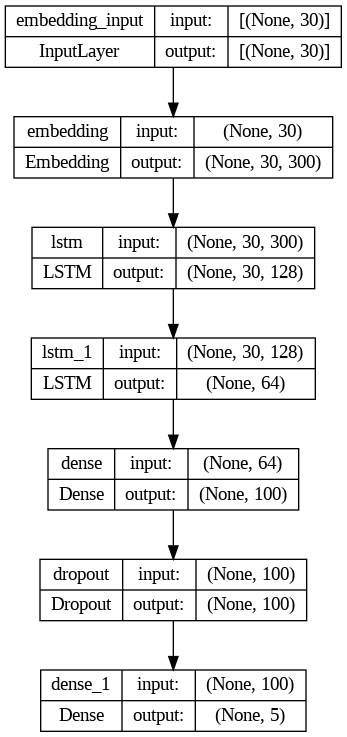

In [18]:
model=Sequential()
model.add(Embedding(len(list(unique_words)),300,input_length=len_max))
model.add(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Early stopping to prevent overfitting


In [19]:
early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_acc', patience = 2)
callback = [early_stopping]

##Fit the model

In [20]:
history=model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=6, batch_size=256, verbose=1, callbacks=callback)

Epoch 1/6
488/488 [==============================] - ETA: 0s - loss: 1.0816 - accuracy: 0.5723

488/488 [==============================] - 455s 901ms/step - loss: 1.0816 - accuracy: 0.5723 - val_loss: 0.8912 - val_accuracy: 0.6394
Epoch 2/6
488/488 [==============================] - ETA: 0s - loss: 0.8473 - accuracy: 0.6596

488/488 [==============================] - 408s 836ms/step - loss: 0.8473 - accuracy: 0.6596 - val_loss: 0.8491 - val_accuracy: 0.6567
Epoch 3/6
488/488 [==============================] - ETA: 0s - loss: 0.7868 - accuracy: 0.6814

488/488 [==============================] - 415s 850ms/step - loss: 0.7868 - accuracy: 0.6814 - val_loss: 0.8379 - val_accuracy: 0.6619
Epoch 4/6
488/488 [==============================] - ETA: 0s - loss: 0.7464 - accuracy: 0.6932

488/488 [==============================] - 415s 849ms/step - loss: 0.7464 - accuracy: 0.6932 - val_loss: 0.8371 - val_accuracy: 0.6623
Epoch 5/6
488/488 [==============================] - ETA: 0s - loss: 0.7116 - accuracy: 0.7053

488/488 [==============================] - 409s 838ms/step - loss: 0.7116 - accuracy: 0.7053 - val_loss: 0.8473 - val_accuracy: 0.6606
Epoch 6/6
488/488 [==============================] - ETA: 0s - loss: 0.6845 - accuracy: 0.7141

488/488 [==============================] - 410s 841ms/step - loss: 0.6845 - accuracy: 0.7141 - val_loss: 0.8527 - val_accuracy: 0.6589


In [21]:
print("\nEpoch Details:")
print(f"+{'-'*8}+{'-'*20}+{'-'*20}+{'-'*20}+{'-'*22}+")
print(f"| {'Epoch':^6} | {'Training loss':^18} | {'Training accuracy':^18} | {'Validation loss':^18} | {'Validation accuracy':^20} |")
print(f"+{'-'*8}+{'-'*20}+{'-'*20}+{'-'*20}+{'-'*22}+")

for epoch, (loss, accuracy, val_loss, val_accuracy) in enumerate(zip(history.history['loss'], history.history['accuracy'], history.history['val_loss'], history.history['val_accuracy'])):
    print(f"| {epoch + 1:^6} | {loss:^18.4f} | {accuracy:^18.4f} | {val_loss:^18.4f} | {val_accuracy:^20.4f} |")

print(f"+{'-'*8}+{'-'*20}+{'-'*20}+{'-'*20}+{'-'*22}+")


Epoch Details:
+--------+--------------------+--------------------+--------------------+----------------------+
| Epoch  |   Training loss    | Training accuracy  |  Validation loss   | Validation accuracy  |
+--------+--------------------+--------------------+--------------------+----------------------+
|   1    |       1.0816       |       0.5723       |       0.8912       |        0.6394        |
|   2    |       0.8473       |       0.6596       |       0.8491       |        0.6567        |
|   3    |       0.7868       |       0.6814       |       0.8379       |        0.6619        |
|   4    |       0.7464       |       0.6932       |       0.8371       |        0.6623        |
|   5    |       0.7116       |       0.7053       |       0.8473       |        0.6606        |
|   6    |       0.6845       |       0.7141       |       0.8527       |        0.6589        |
+--------+--------------------+--------------------+--------------------+----------------------+


##Visualize learning curve

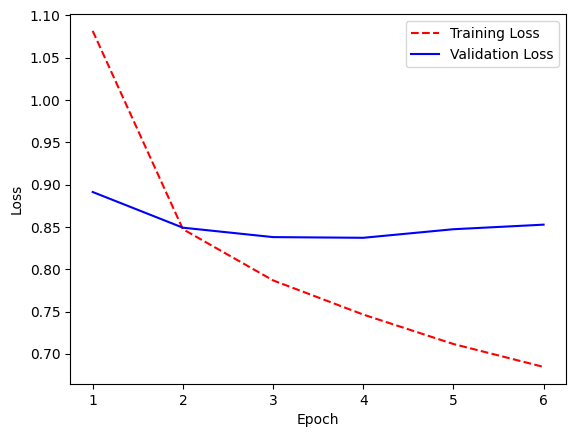

In [22]:
epoch_count = range(1, len(history.history['loss']) + 1)
plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

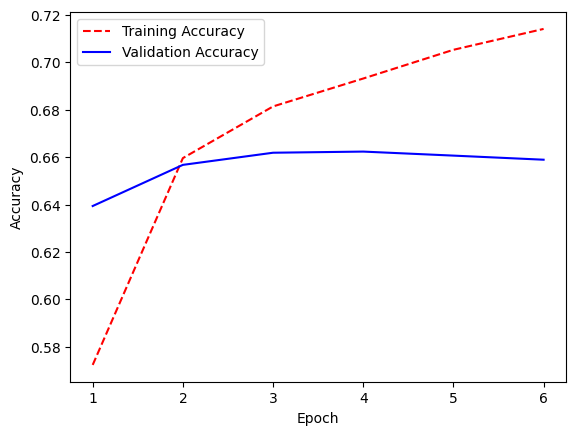

In [27]:
epoch_count = range(1, len(history.history['accuracy']) + 1)

plt.plot(epoch_count, history.history['accuracy'], 'r--')
plt.plot(epoch_count, history.history['val_accuracy'], 'b-')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

##Confusion Matrix

976/976 [==============================] - 29s 30ms/step


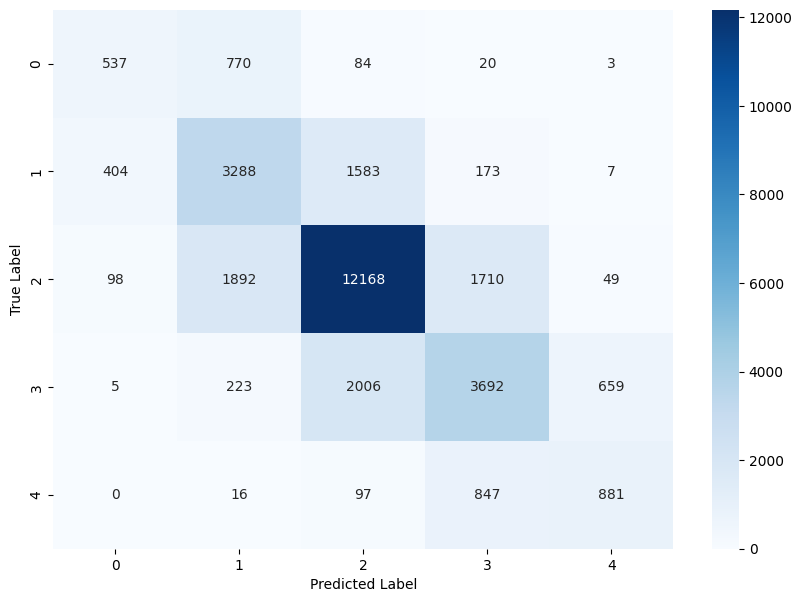

              precision    recall  f1-score   support

           0       0.51      0.38      0.44      1414
           1       0.53      0.60      0.56      5455
           2       0.76      0.76      0.76     15917
           3       0.57      0.56      0.57      6585
           4       0.55      0.48      0.51      1841

    accuracy                           0.66     31212
   macro avg       0.59      0.56      0.57     31212
weighted avg       0.66      0.66      0.66     31212



In [23]:
#Make predictions on the validation set
y_val_pred_prob = model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_prob, axis=1)

# Decode true labels
y_val_true = np.argmax(y_val, axis=1)

# Step 2: Create confusion matrix
cm = confusion_matrix(y_val_true, y_val_pred)

# Step 3: Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2', '3', '4'], yticklabels=['0', '1', '2', '3', '4'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
print(classification_report(y_val_true, y_val_pred))

## Submission

In [24]:
#make the predictions with trained model and submit the predictions.
#y_pred=model.predict_classes(X_test)

predict_x=model.predict(X_test)
y_pred = np.argmax(predict_x, axis=1)

sub_file = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sampleSubmission.csv',sep=',')
sub_file.Sentiment=y_pred
sub_file.to_csv('/content/drive/MyDrive/Colab Notebooks/Submission.csv',index=False)

469/469 [==============================] - 14s 30ms/step


In [25]:
y_pred[slice(20)]

array([0, 1, 1, 3, 4, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 2])

In [26]:
predict_x_percent = predict_x * 100
for i in range(10):
    print(f"Sample {i+1} predictions in percentages:")
    print(f"Negative: {predict_x_percent[i][0]:.2f}%")
    print(f"Somewhat Negative: {predict_x_percent[i][1]:.2f}%")
    print(f"Neutral: {predict_x_percent[i][2]:.2f}%")
    print(f"Somewhat Positive: {predict_x_percent[i][3]:.2f}%")
    print(f"Positive: {predict_x_percent[i][4]:.2f}%")
    print()


Sample 1 predictions in percentages:
Negative: 77.34%
Somewhat Negative: 21.74%
Neutral: 0.91%
Somewhat Positive: 0.01%
Positive: 0.00%

Sample 2 predictions in percentages:
Negative: 23.25%
Somewhat Negative: 49.57%
Neutral: 23.75%
Somewhat Positive: 3.19%
Positive: 0.25%

Sample 3 predictions in percentages:
Negative: 35.83%
Somewhat Negative: 48.15%
Neutral: 14.76%
Somewhat Positive: 1.16%
Positive: 0.10%

Sample 4 predictions in percentages:
Negative: 0.04%
Somewhat Negative: 0.68%
Neutral: 11.15%
Somewhat Positive: 69.08%
Positive: 19.06%

Sample 5 predictions in percentages:
Negative: 0.00%
Somewhat Negative: 0.01%
Neutral: 0.10%
Somewhat Positive: 14.47%
Positive: 85.43%

Sample 6 predictions in percentages:
Negative: 0.02%
Somewhat Negative: 0.75%
Neutral: 15.26%
Somewhat Positive: 75.96%
Positive: 8.01%

Sample 7 predictions in percentages:
Negative: 0.02%
Somewhat Negative: 0.75%
Neutral: 15.26%
Somewhat Positive: 75.96%
Positive: 8.01%

Sample 8 predictions in percentages:
N